In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import zipfile

In [2]:
import zipfile
with zipfile.ZipFile('dataset.zip') as file:
    file.extractall()

In [3]:
# Load the VGG16 model with pre-trained weights
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [4]:
# freeze the layer except 4 layer
for layer in vgg16.layers[:-4]:
    layer.trainable = False

In [5]:
# check the trainable layer
for layer in vgg16.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


In [6]:
# Add custom layers
x = vgg16.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [7]:
# model to train
model = Model(inputs=vgg16.input, outputs=predictions)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,635,777 (90.16 MB)

 Trainable params: 15,997,441 (61.03 MB)

 Non-trainable params: 7,638,336 (29.14 MB)

In [9]:
# train mopdel
model.compile(
    optimizer='Adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
training_set = train_datagen.flow_from_directory(
    'dataset/training_set',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary')

Found 6362 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [12]:
# Callbacks for better training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [13]:
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=60,
    validation_data=test_set,
    validation_steps=len(test_set)
    )

Epoch 1/60


C:\Users\adeeb\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.9293 - loss: 0.1764 - val_accuracy: 0.8000 - val_loss: 0.6810
Epoch 2/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/60


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


199/199 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9749 - loss: 0.0673 - val_accuracy: 0.9400 - val_loss: 0.1499
Epoch 4/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9844 - loss: 0.0506 - val_accuracy: 0.9950 - val_loss: 0.0253
Epoch 6/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9854 - loss: 0.0506 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 8/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9914 - loss: 0.0228 - val_accuracy: 0.9600 - val_loss: 0.0821
Epoch 10/60
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - 

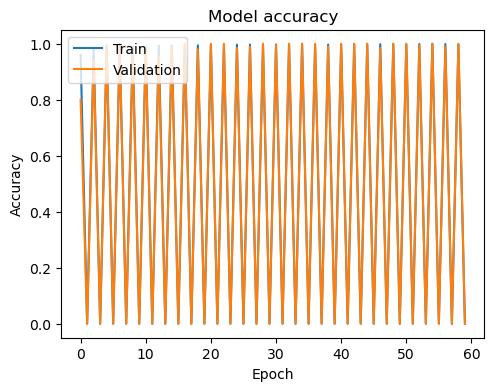

In [14]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

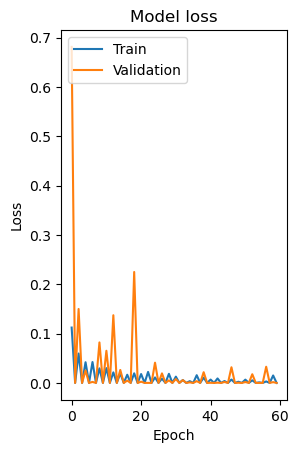

In [15]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f'Overall Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Overall Test Loss: {test_loss * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 1.0000 - loss: 0.0016
Overall Test Accuracy: 100.00%
Overall Test Loss: 0.15%


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step


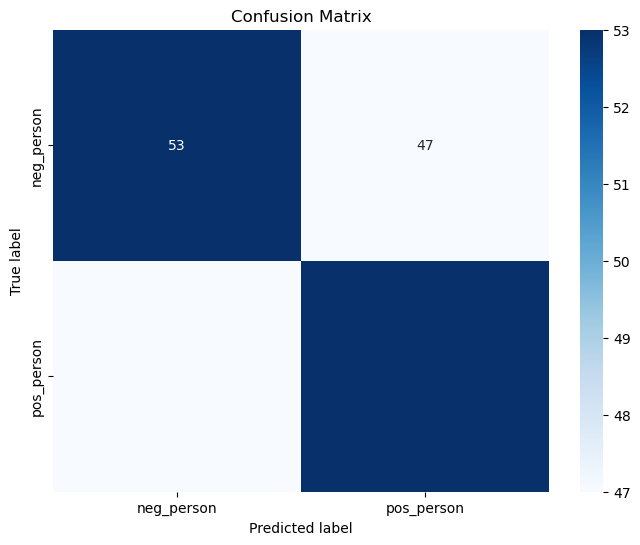

In [17]:
# Plot confusion matrix
Y_pred = model.predict(test_set)
y_pred = np.round(Y_pred).astype(int).flatten()
y_true = test_set.classes
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()